<h1 align=center><font size = 5>Using Foursquare to index happiness in Toronto</font></h1>

## Part 1. Building dataframe

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [2]:
!pip install beautifulsoup4
!pip install pgeocode
!pip install geopy
!pip install yellowbrick

import sys
import pgeocode
from yellowbrick.cluster.elbow import kelbow_visualizer

import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
import requests # library to handle requests
from bs4 import BeautifulSoup

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude value

from branca.element import Template, MacroElement

print('Libraries imported.')

     |████████████████████████████████| 122kB 19.1MB/s eta 0:00:01
     |████████████████████████████████| 112kB 18.3MB/s eta 0:00:01
     |████████████████████████████████| 276kB 1.0MB/s eta 0:00:01
Libraries imported.


### Load wikipedia page with Toronto postal codes  and neighborhoods

In [3]:
html_data = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M").text #Using the requests library to download the webpage

In [4]:
soup = BeautifulSoup(html_data,"html5lib") #Parsing the html data using beautiful_soup

#### Extracting the table using beautiful soup and store it into dataframe 

In [5]:
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        #print(row.span.text)
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).split('/')[0]).replace(')',' ')).strip(' ') #taking only first neighborhood in a list of each postcode
        table_contents.append(cell)

# print(table_contents)
df=pd.DataFrame(table_contents)
# print(df['Neighborhood'].tail(50))
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

## Part 2. Getting coordinates by the postcodes

#### Using pgeocode to get coordinates. I didn't manage with Geocoder, couldnt take its key

In [6]:
pgeocode.Nominatim('ca')
geolocator = pgeocode.Nominatim('ca')
postal_codes = df['PostalCode'].tolist()
latitudes = []
longitudes = []
for i, postal_code in enumerate(postal_codes):
    # initialize your variable to None
    #print(f'--Getting Postal Code: {postal_code}')
    g = geolocator.query_postal_code(postal_code)
    
    if not g.empty:
        #print(f'Postal Code {postal_code} has been retrieved. {len(postal_codes) - (i + 1)} codes left')
        latitudes.append(g.latitude)
        longitudes.append(g.longitude)

df['Latitude'] = latitudes
df['Longitude'] = longitudes
df=df.dropna() #just in case

## Part3. Explore and cluster the neighborhoods in Toronto

#### Use geopy library to get the latitude and longitude values of New York City.

In [7]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Toronto are 43.6534817, -79.3839347.


#### Create a map of Toronto with neighborhoods superimposed on top.

In [8]:
# create map of Toronto using latitude and longitude values

map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

#### Define Foursquare Credentials and Version

In [17]:
#CLIENT_ID = 'LRMISDIUICOOCBKRAN1UYLDSEKCDFQ3KRT5JWAMIY2XV0WV4' # your Foursquare ID
#CLIENT_SECRET = '11PWCHTSLP0IO5XYGTOULGAA5HQRTG4VSDIN1REYOPY3X3M4' # your Foursquare Secret
#CLIENT_ID = 'JGSP4L0DPSECDQ4JJKAKR301CSHUMCAOSFPOK0O1KDE2KEDQ' # your Foursquare ID
#CLIENT_SECRET = 'I4MOFCRQKER1Y5IDECXPRH5KI2FVJSXAVVKDYG2MGHIJLV0E' # your Foursquare Secret
#CLIENT_ID = '0FFJN43JXVVYE5PNRSPV5AKIMCDYTSPIJ0OQ55BKR5S1QWYN'
#CLIENT_SECRET = 'PJZLBD1JF5KUMKWBAXRH0KTNQGOWGWAGTRNTPI04AVUSLZEL'
#CLIENT_ID = 'OGENN5BV4QV0IG0ZQ3FHATIJPRMAAEYWY45IPJQF5TOI5NDR'
#CLIENT_SECRET = 'UMNCTJ4KOMXXP4ZXTEJ5JFQYW55CWPDT51ZYB3ZWKKNLDXGT'
#CLIENT_ID = '4XT5NQLSYNSL0V2E1ZNNYKPORFLGGERVKYUGVHHIDVPHQG05'
#CLIENT_SECRET = 'VR0IPEVMP1S30NLR4JVT0IBMESM2BW4GFC3RVOUJCJNKXSBD'
CLIENT_ID = '5SURBJA5NUVADJBODCV4NF1ELOS2N0UBD0U0WCZYYKAOW1FA'
CLIENT_SECRET = '11HO2EAYMWGTCREG3MYZIICLN3UNHQK5AR4GUSKMOIWLC5MA'
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 5SURBJA5NUVADJBODCV4NF1ELOS2N0UBD0U0WCZYYKAOW1FA
CLIENT_SECRET:11HO2EAYMWGTCREG3MYZIICLN3UNHQK5AR4GUSKMOIWLC5MA


### Explore Neighborhoods in Toronto

#### Let's read ratings from file we saved before. This code we run repeatedly, until all the ratings are read from Foursquare

In [18]:
premium_counter = 0 # Global counter, Foursquare personal account limit on premium calls
try:
    with open('venues_ratings.csv', 'r') as f: #if csv file with ratings aready exists
        RatingFrame = pd.read_csv(f, header=None, index_col=0)
    RatingFrame.reset_index(drop=True,inplace=True)
    RatingFrame.columns = ['venue_id', 'venue_rating']
except: #if there is no file we just initialize the file and our RatingFrame 
    RF=pd.DataFrame(list())
    print('No')
    RF.to_csv('venues_ratings.csv', header=None)
    RatingFrame = pd.DataFrame(columns=['venue_id', 'venue_rating']) #global dataframe for ratings

#### Function for getting venue ratings

In [11]:
def getVenueRating(venue_id):
    global premium_counter, RatingFrame # premium counter counts premium calls, RatingFrame saves ratings
    if premium_counter == 500:
        with open('venues_ratings.csv', 'w') as f:
            RatingFrame.to_csv(f, header=None) #save to csv file and exit
        print('500 premium requests')
        sys.exit()
    elif any(RatingFrame.venue_id == venue_id):
        return (RatingFrame.loc[RatingFrame['venue_id'] == venue_id,'venue_rating'].values[0]) #if venue_id is already in dataframe 
    else:
        premium_counter = premium_counter+1
        print(premium_counter)
        try:
            venue_rating=requests.get('https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET,
            VERSION)).json()["response"]['venue']['rating'] #read rating from Foursquare
        except:
            venue_rating = 0
            print('empty response') #no information
        RatingFrame = RatingFrame.append({'venue_id':venue_id,'venue_rating':venue_rating},ignore_index=True)
        return (venue_rating)
    

#### Let's create a function to explore the neighborhoods in Toronto

In [13]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    global RatingFrame
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],
            v['venue']['id'],
            getVenueRating(v['venue']['id'])
        ) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category',
                  'Venue ID',
                  'Venue Rating']
    with open('venues_ratings.csv', 'w') as f:
            RatingFrame.to_csv(f, header=None)
    return(nearby_venues)

#### Now write the code to run the above function on each neighborhood and create a new dataframe called _toronto_venues_.

In [ ]:
toronto_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

### Analyze Each Neighborhood

In [20]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


And let's examine the new dataframe size.

In [18]:
toronto_onehot.shape

(2156, 264)

In [21]:
toronto_venues['Venue Rating'] = toronto_venues['Venue Rating'].astype(int) #to multiply our dataframe by ratings they shall be integer

In [ ]:
####Onehot encoding for dataframe with ratings: toronto_onehot_r

In [22]:
toronto_d=pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")
toronto_onehot_r=toronto_d.mul(toronto_venues['Venue Rating'],axis=0) #adding ratings to dataframe by mul() method
# add neighborhood column back to dataframe
toronto_onehot_r['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot_r.columns[-1]] + list(toronto_onehot_r.columns[:-1])
toronto_onehot_r = toronto_onehot_r[fixed_columns]

toronto_onehot_r.head()

,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [23]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Art Gallery,Art Museum,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Alderwood,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Bathurst Manor,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Bedford Park,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,Willowdale West,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93,Woburn,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
94,Woodbine Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95,York Mills,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
toronto_grouped_r = toronto_onehot_r.groupby('Neighborhood').mean().reset_index()
toronto_grouped_r

,Neighborhood,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Art Gallery,Art Museum,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Alderwood,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Bathurst Manor,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Bedford Park,0.0,0.0,0.0,0.0,0.0,0.0,0.24,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,Willowdale West,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93,Woburn,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
94,Woodbine Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95,York Mills,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Let's confirm the new size

In [23]:
toronto_grouped.shape

(97, 264)

#### Let's print each neighborhood along with the top 5 most common venues

In [25]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                       venue  freq
0            Badminton Court  0.25
1               Skating Rink  0.25
2             Breakfast Spot  0.25
3  Latin American Restaurant  0.25
4                     Museum  0.00


----Alderwood----
               venue  freq
0  Convenience Store  0.14
1       Dance Studio  0.14
2     Sandwich Place  0.14
3        Coffee Shop  0.14
4                Gym  0.14


----Bathurst Manor----
                       venue  freq
0   Mediterranean Restaurant  0.17
1        Fried Chicken Joint  0.17
2              Deli / Bodega  0.17
3                Coffee Shop  0.17
4  Middle Eastern Restaurant  0.17


----Bayview Village----
                        venue  freq
0                 Flower Shop  0.25
1                       Trail  0.25
2                        Park  0.25
3                 Gas Station  0.25
4  Modern European Restaurant  0.00


----Bedford Park----
                  venue  freq
0           Coffee Shop  0.08
1    Italian Restaurant  0.08


#### Let's put that into a _pandas_ dataframe

First, let's write a function to sort the venues in descending order.

In [26]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [50]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Breakfast Spot,Latin American Restaurant,Skating Rink,Badminton Court,Creperie,Cuban Restaurant,Fish Market,Fish & Chips Shop,Field,Fast Food Restaurant
1,Alderwood,Pizza Place,Pub,Sandwich Place,Convenience Store,Dance Studio,Gym,Coffee Shop,Doner Restaurant,Donut Shop,Dumpling Restaurant
2,Bathurst Manor,Pizza Place,Coffee Shop,Mediterranean Restaurant,Middle Eastern Restaurant,Deli / Bodega,Fried Chicken Joint,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room
3,Bayview Village,Flower Shop,Gas Station,Park,Trail,Escape Room,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant
4,Bedford Park,Restaurant,Italian Restaurant,Coffee Shop,Sandwich Place,Liquor Store,Pizza Place,Sushi Restaurant,Juice Bar,Thai Restaurant,Café


### Cluster Neighborhoods

Run _k_-means to cluster the neighborhood into 5 clusters.

In [49]:
# set number of clusters
kclusters = 4

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 0, 0, 3, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3,
       3, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 3, 1, 0, 3, 0, 3, 0, 0, 0, 3,
       0, 0, 3, 2, 0, 3, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0,
       3, 0, 0, 0, 3, 0, 0, 0, 3], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [51]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df.drop('PostalCode',1).groupby('Neighborhood').mean().reset_index()

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,43.7946,-79.2644,0.0,Breakfast Spot,Latin American Restaurant,Skating Rink,Badminton Court,Creperie,Cuban Restaurant,Fish Market,Fish & Chips Shop,Field,Fast Food Restaurant
1,Alderwood,43.6021,-79.5402,0.0,Pizza Place,Pub,Sandwich Place,Convenience Store,Dance Studio,Gym,Coffee Shop,Doner Restaurant,Donut Shop,Dumpling Restaurant
2,Bathurst Manor,43.7535,-79.4472,0.0,Pizza Place,Coffee Shop,Mediterranean Restaurant,Middle Eastern Restaurant,Deli / Bodega,Fried Chicken Joint,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room
3,Bayview Village,43.7797,-79.3813,3.0,Flower Shop,Gas Station,Park,Trail,Escape Room,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant
4,Bedford Park,43.7335,-79.4177,0.0,Restaurant,Italian Restaurant,Coffee Shop,Sandwich Place,Liquor Store,Pizza Place,Sushi Restaurant,Juice Bar,Thai Restaurant,Café


In [52]:
toronto_merged.dropna(axis=0, inplace = True) # remove neighbourhoods with no venues

Finally, let's visualize the resulting clusters

In [53]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels'].astype(int)):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Happiness map

In [32]:
#colorsQ = ['#000000','#9A0EEA', '#0000FF', '#00FFFF', '#04D8B2', '#00FF00', '#15B01A', '#FFFF14', '#F97306', '#A9561E', '#E50000']
colorsQ = ['black','violet', 'blue', 'cyan', 'aquamarine', 'lime', 'green', 'yellow', 'orange', 'sienna', 'red']
toronto_vg = toronto_venues.groupby('Neighborhood').mean().reset_index()

#### Draggable legend 

In [33]:
template = """
{% macro html(this, kwargs) %}
<!doctype html>
<html lang="en">

<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>

<body>
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; top: 20px;'>
     
<div class='legend-title'>Average ratings</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:red;opacity:0.7;'></span>10</li>
    <li><span style='background:sienna;opacity:0.7;'></span>9</li>
    <li><span style='background:orange;opacity:0.7;'></span>8</li>
    <li><span style='background:yellow;opacity:0.7;'></span>7</li>
    <li><span style='background:green;opacity:0.7;'></span>6</li>
    <li><span style='background:lime;opacity:0.7;'></span>5</li>
    <li><span style='background:aquamarine;opacity:0.7;'></span>4</li>
    <li><span style='background:cyan;opacity:0.7;'></span>3</li>
    <li><span style='background:blue;opacity:0.7;'></span>2</li>
    <li><span style='background:violet;opacity:0.7;'></span>1</li>
    <li><span style='background:black;opacity:0.7;'></span>0</li>


      </ul>
</div>
</div>
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>

{% endmacro %}"""
macro = MacroElement()
macro._template = Template(template)

In [34]:
map_ratings = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to the map
markers_colors = []
for lat, lon, poi, color_index in zip(toronto_vg['Neighborhood Latitude'], toronto_vg['Neighborhood Longitude'], toronto_vg['Neighborhood'], toronto_vg['Venue Rating'].astype(int)):
    label = folium.Popup(str(poi) + ' Rating=' + str(color_index), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        #color = '#E50000',
        color=colorsQ[color_index],
        fill=True,
        fill_color=colorsQ[color_index],
        fill_opacity=0.7).add_to(map_ratings)
map_ratings.get_root().add_child(macro)       
map_ratings

###  Examine Clusters

#### Cluster 1

In [54]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[0] + list(range(4, toronto_merged.shape[1]))]].head(50)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Breakfast Spot,Latin American Restaurant,Skating Rink,Badminton Court,Creperie,Cuban Restaurant,Fish Market,Fish & Chips Shop,Field,Fast Food Restaurant
1,Alderwood,Pizza Place,Pub,Sandwich Place,Convenience Store,Dance Studio,Gym,Coffee Shop,Doner Restaurant,Donut Shop,Dumpling Restaurant
2,Bathurst Manor,Pizza Place,Coffee Shop,Mediterranean Restaurant,Middle Eastern Restaurant,Deli / Bodega,Fried Chicken Joint,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room
4,Bedford Park,Restaurant,Italian Restaurant,Coffee Shop,Sandwich Place,Liquor Store,Pizza Place,Sushi Restaurant,Juice Bar,Thai Restaurant,Café
5,Berczy Park,Coffee Shop,Hotel,Bakery,Café,Seafood Restaurant,Cocktail Bar,Restaurant,Beer Bar,Japanese Restaurant,Breakfast Spot
6,Birch Cliff,General Entertainment,College Stadium,Café,Skating Rink,Electronics Store,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant
7,Brockton,Café,Coffee Shop,Bar,Thrift / Vintage Store,Breakfast Spot,Gift Shop,Cocktail Bar,Japanese Restaurant,Beach Bar,Supermarket
8,CN Tower,Italian Restaurant,Coffee Shop,Café,Bar,Grocery Store,Restaurant,Bank,Bakery,Park,Speakeasy
10,Cedarbrae,Construction & Landscaping,Lounge,Flea Market,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant
11,Central Bay Street,Coffee Shop,Restaurant,Pizza Place,Sandwich Place,Café,Bubble Tea Shop,Italian Restaurant,Middle Eastern Restaurant,Fast Food Restaurant,Juice Bar


#### Cluster 2: Intersection

In [55]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[0] + list(range(4, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
55,Milliken,Pharmacy,Intersection,Women's Store,Ethiopian Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Event Space
58,New Toronto,Intersection,Women's Store,Dog Run,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant


#### Cluster 3: Rouge Hill

In [56]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[0] + list(range(4, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
71,Rouge Hill,Bar,Women's Store,Doner Restaurant,Fish Market,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space


#### Cluster 4: Park

In [57]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[0] + list(range(4, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Bayview Village,Flower Shop,Gas Station,Park,Trail,Escape Room,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant
9,Caledonia-Fairbanks,Park,Women's Store,Gym,Beer Store,Bakery,Mexican Restaurant,Sporting Goods Shop,Farmers Market,Falafel Restaurant,Fast Food Restaurant
21,Don Mills North,Park,Pool,Furniture / Home Store,Women's Store,Escape Room,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Event Space
22,Don Mills South,Park,Home Service,Gym,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant
27,Downsview West,Home Service,Park,Vietnamese Restaurant,Pool,Electronics Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
39,Harbourfront East,Music Venue,Park,Harbor / Marina,Café,Women's Store,Escape Room,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store
40,High Park,Park,Women's Store,Dog Run,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant
41,Hillcrest Village,Residential Building (Apartment / Condo),Park,Women's Store,Escape Room,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant
51,Lawrence Park,Photography Studio,Park,Lawyer,Women's Store,Escape Room,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Event Space
57,Moore Park,Park,Grocery Store,Gym,Thai Restaurant,Playground,Falafel Restaurant,Event Space,Ethiopian Restaurant,Farmers Market,Discount Store


In [ ]:
num_top_venues = 5

for hood in toronto_grouped_r['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped_r[toronto_grouped_r['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

### Building clusters for data with ratings

In [37]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted_r = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted_r['Neighborhood'] = toronto_grouped_r['Neighborhood']

for ind in np.arange(toronto_grouped_r.shape[0]):
    neighborhoods_venues_sorted_r.iloc[ind, 1:] = return_most_common_venues(toronto_grouped_r.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted_r.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Breakfast Spot,Latin American Restaurant,Ethiopian Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Women's Store,Doner Restaurant
1,Alderwood,Pizza Place,Pub,Gym,Coffee Shop,Sandwich Place,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
2,Bathurst Manor,Mediterranean Restaurant,Coffee Shop,Middle Eastern Restaurant,Deli / Bodega,Fried Chicken Joint,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space
3,Bayview Village,Women's Store,Concert Hall,Fish Market,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant
4,Bedford Park,Restaurant,Coffee Shop,Italian Restaurant,Sandwich Place,Café,Indian Restaurant,Pub,Thai Restaurant,Pizza Place,Juice Bar


In [41]:
# set number of clusters
kclusters = 4

toronto_grouped_r_clustering = toronto_grouped_r.drop('Neighborhood', 1)

# run k-means clustering
kmeans_r = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_r_clustering)

# check cluster labels generated for each row in the dataframe
kmeans_r.labels_[0:10] 

array([0, 2, 2, 0, 0, 2, 0, 0, 0, 0], dtype=int32)

#### Elbow method

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


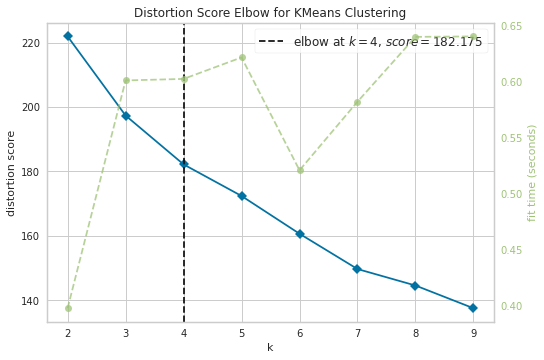

KElbowVisualizer(ax=<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
         estimator=KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=9, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=4, tol=0.0001, verbose=0),
         k=None, locate_elbow=True, metric='distortion', timings=True)

In [39]:
kelbow_visualizer(KMeans(random_state=4), toronto_grouped_r_clustering, k=(2,10)) #data with ratings

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/yellowbrick/utils/kneed.py:155: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


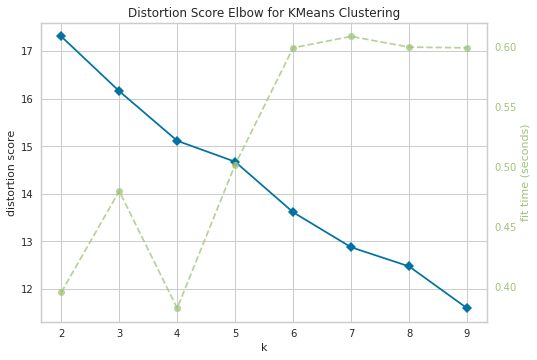

KElbowVisualizer(ax=<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
         estimator=KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=9, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=4, tol=0.0001, verbose=0),
         k=None, locate_elbow=True, metric='distortion', timings=True)

In [40]:
kelbow_visualizer(KMeans(random_state=4), toronto_grouped_clustering, k=(2,10)) #data with no ratings

In [42]:
# add clustering labels
neighborhoods_venues_sorted_r.insert(0, 'Cluster Labels', kmeans_r.labels_)

toronto_merged_r = df.drop('PostalCode',1).groupby('Neighborhood').mean().reset_index()

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
toronto_merged_r = toronto_merged_r.join(neighborhoods_venues_sorted_r.set_index('Neighborhood'), on='Neighborhood')

toronto_merged_r.head() # check the last columns!

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,43.7946,-79.2644,0.0,Breakfast Spot,Latin American Restaurant,Ethiopian Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Women's Store,Doner Restaurant
1,Alderwood,43.6021,-79.5402,2.0,Pizza Place,Pub,Gym,Coffee Shop,Sandwich Place,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
2,Bathurst Manor,43.7535,-79.4472,2.0,Mediterranean Restaurant,Coffee Shop,Middle Eastern Restaurant,Deli / Bodega,Fried Chicken Joint,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space
3,Bayview Village,43.7797,-79.3813,0.0,Women's Store,Concert Hall,Fish Market,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant
4,Bedford Park,43.7335,-79.4177,0.0,Restaurant,Coffee Shop,Italian Restaurant,Sandwich Place,Café,Indian Restaurant,Pub,Thai Restaurant,Pizza Place,Juice Bar


In [43]:
toronto_merged_r.dropna(axis=0, inplace = True)

In [44]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged_r['Latitude'], toronto_merged_r['Longitude'], toronto_merged_r['Neighborhood'], toronto_merged_r['Cluster Labels'].astype(int)):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Cluster 1: Women's stores/Concert Halls

In [59]:
toronto_merged_r.loc[toronto_merged_r['Cluster Labels'] == 0, toronto_merged_r.columns[[0] + list(range(4, toronto_merged_r.shape[1]))]].head(50)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Breakfast Spot,Latin American Restaurant,Ethiopian Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Women's Store,Doner Restaurant
3,Bayview Village,Women's Store,Concert Hall,Fish Market,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant
4,Bedford Park,Restaurant,Coffee Shop,Italian Restaurant,Sandwich Place,Café,Indian Restaurant,Pub,Thai Restaurant,Pizza Place,Juice Bar
6,Birch Cliff,Café,General Entertainment,Women's Store,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant
7,Brockton,Coffee Shop,Café,Gift Shop,Bar,Thrift / Vintage Store,Breakfast Spot,Japanese Restaurant,Bakery,Diner,Arts & Crafts Store
8,CN Tower,Italian Restaurant,Coffee Shop,Bar,Café,Gym / Fitness Center,Bakery,Speakeasy,French Restaurant,Park,Restaurant
9,Caledonia-Fairbanks,Mexican Restaurant,Bakery,Women's Store,Doner Restaurant,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space
10,Cedarbrae,Women's Store,Concert Hall,Fish Market,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant
12,Christie,Café,Grocery Store,Park,Playground,Coffee Shop,Candy Store,Women's Store,Electronics Store,Donut Shop,Dumpling Restaurant
13,Church and Wellesley,Japanese Restaurant,Sushi Restaurant,Coffee Shop,Restaurant,Gay Bar,Yoga Studio,Men's Store,Mediterranean Restaurant,Hotel,Fast Food Restaurant


#### Cluster 2: High Park

In [46]:
toronto_merged_r.loc[toronto_merged_r['Cluster Labels'] == 1, toronto_merged_r.columns[[0] + list(range(4, toronto_merged_r.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
40,High Park,Park,Women's Store,Dog Run,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant


#### Cluster 3: Coffee shops

In [47]:
toronto_merged_r.loc[toronto_merged_r['Cluster Labels'] == 2, toronto_merged_r.columns[[0] + list(range(4, toronto_merged_r.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Alderwood,Pizza Place,Pub,Gym,Coffee Shop,Sandwich Place,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
2,Bathurst Manor,Mediterranean Restaurant,Coffee Shop,Middle Eastern Restaurant,Deli / Bodega,Fried Chicken Joint,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space
5,Berczy Park,Coffee Shop,Bakery,Hotel,Café,Seafood Restaurant,Cocktail Bar,Japanese Restaurant,Beer Bar,Restaurant,Farmers Market
11,Central Bay Street,Coffee Shop,Café,Pizza Place,Middle Eastern Restaurant,Sandwich Place,Bubble Tea Shop,Fast Food Restaurant,Italian Restaurant,Breakfast Spot,Park
14,Clairville,Mediterranean Restaurant,Coffee Shop,Hotel,Women's Store,Ethiopian Restaurant,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Falafel Restaurant
16,Cliffside,Ice Cream Shop,Coffee Shop,Bistro,Pizza Place,Sandwich Place,Pharmacy,Gym Pool,Fast Food Restaurant,Falafel Restaurant,Event Space
17,Commerce Court,Coffee Shop,Hotel,Café,Restaurant,Gym,American Restaurant,Seafood Restaurant,Japanese Restaurant,Steakhouse,Asian Restaurant
20,Del Ray,Fast Food Restaurant,Coffee Shop,Women's Store,Dog Run,Fish & Chips Shop,Field,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant
25,Downsview East,Airport,Coffee Shop,Women's Store,Event Space,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Falafel Restaurant
29,Enclave of M4L,Coffee Shop,Restaurant,Sushi Restaurant,Breakfast Spot,Italian Restaurant,Deli / Bodega,Bookstore,Bank,Yoga Studio,Japanese Restaurant


#### Cluster 4: Bakeries

In [48]:
toronto_merged_r.loc[toronto_merged_r['Cluster Labels'] == 3, toronto_merged_r.columns[[0] + list(range(4, toronto_merged_r.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
23,Dorset Park,Bakery,Women's Store,Doner Restaurant,Fish Market,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space
59,North Park,Bakery,Women's Store,Doner Restaurant,Fish Market,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space
